In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as custom_tfms
import seaborn as sns

torch.cuda.set_device(0) 


def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df

In [2]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
label_df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(label_df)


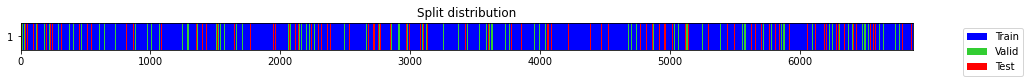

((#5503) [3730,369,1166,1104,1256,1925,1397,6851,5431,5658...],
 (#687) [3536,5567,3053,1591,268,2755,6308,2063,3139,3885...],
 (#687) [4921,3129,4389,2920,319,6726,55,1263,3608,2788...])

In [3]:
splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

In [4]:
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [ ]:
from transformation_funcs import *
def save_callback(study, trial):
    if study.best_trial == trial:
        PATH = Path('./models/inception_multilabel.pkl')
        PATH.parent.mkdir(parents=True, exist_ok=True)
        global learn
        learn.export(PATH)
def objective(trial:optuna.Trial):    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     
    tfms = []
    random_shift = trial.suggest_float('rand_shift', 0.0, 0.5, step=.05)
    window_slice = trial.suggest_float("window_slice", 0.0, 0.2, step=.05)
    window_warp = trial.suggest_float("window_warp", 0.0, 100, step=10) 
    noise = trial.suggest_float("noise", 0.0, 50, step=.5) 
#     rescale = trial.suggest_float("scale", 0.2, 0.8, step=.1) 
    norm_type = trial.suggest_categorical('norm_type', ["standardize", "normalize"])
    depth = trial.suggest_int('depth', 3,11,step=1) # search through all integer values between 3 and 9 with 3 increment steps
    
    if norm_type == "standardize":
        batch_tfms = [TSStandardize(by_sample=True),WindowWarping(window_warp),RandomShift(random_shift),MulNoise(noise),WindowSlicing(window_slice),]
    else:
        batch_tfms = [Normalize(),WindowWarping(window_warp),RandomShift(random_shift),MulNoise(noise),WindowSlicing(window_slice),]
    tfms = [None,TSMultiLabelClassification()]

    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 

    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=depth,)
    global learn
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


#     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
    learn.fit_one_cycle(100, lr_max=0.007)

    # Return the objective value
    return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

study_name = "inception_study3" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
                            pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(n_warmup_steps=25),patience=20),)

study.optimize(objective, n_trials=100,callbacks=[save_callback])

In [ ]:
from transformation_funcs import *
tfms = [None,TSMultiLabelClassification()]
# batch_tfms = [TSStandardize(by_sample=True),WindowWarping(100),WindowSlicing(0.2),RandomShift(0.2),MulNoise(0.5),Scale(scale_factor=0.5),]
batch_tfms = [TSStandardize(by_sample=True),WindowWarping(100),RandomShift(0.2),MulNoise(0.5)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[32, 128], batch_tfms=batch_tfms, num_workers=0) 
# reorganize y dataframe using dl's label/vocab mapping and count pos_weights
y = y[dls.vocab.o2i.keys()]
pos_weight = torch.tensor((len(y)-y.sum())/(y.sum()+1e-5))
metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=4,)
learn = Learner(dls, model, metrics=metrics, loss_func=nn.BCEWithLogitsLoss(),cbs=ShowGraph())
learn.fit_one_cycle(200, lr_max=0.004178080960048705)
learn.recorder.plot_metrics()

In [8]:
# PATH = Path('./models/inception_multilabel_bestparam.pkl')
# PATH.parent.mkdir(parents=True, exist_ok=True)
# learn.export(PATH)

In [25]:
PATH = Path('./models/inception_multilabel.pkl')
learn = load_learner(PATH, cpu=False)


In [26]:
# Xtfms = [[TSRandomShift(magnitude=best_params["rand_shift"]),TSMagMulNoise(best_params["noise"]),TSWindowSlicing(magnitude=best_params["window_slice"]),custom_tfms.Resample(scale_factor=best_params["scale"])],TSMultiLabelClassification()]
# if best_params["normalize"]!=0:
#     Xtfms[0] = Xtfms[0].append(custom_tfms.Normalize())

Xtfms = [None,TSMultiLabelClassification()]
# batch_tfms = [WindowWarping(0.1),WindowSlicing(0.3),RandomShift(0.2),MulNoise(0.5),Scale(scale_factor=0.5),]
bp = {'depth': 10,
 'noise': 7.5,
 'norm_type': 'standardize',
 'rand_shift': 0.30000000000000004,
 'window_slice': 0.0,
 'window_warp': 20.0}
batch_tfms = [TSStandardize(by_sample=True),WindowWarping(bp["window_warp"]),WindowSlicing(bp["window_slice"]),RandomShift(bp["rand_shift"]),
              MulNoise(bp["noise"])]
dsets = TSDatasets(X.astype(float), y_multi, tfms=Xtfms, splits=(splits[0],splits[2])) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

y_pred=(valid_preds>0)
y_test=valid_targets

print(classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys()))

                              precision    recall  f1-score   support

         1st degree av block       0.91      0.93      0.92        73
         atrial fibrillation       0.90      0.91      0.91       122
    left bundle branch block       0.92      0.92      0.92        24
premature atrial contraction       0.56      0.45      0.50        60
   right bundle branch block       0.93      0.92      0.93       185
                sinus rhythm       0.72      0.68      0.70        92
               st depression       0.82      0.84      0.83        87
                st elevation       0.47      0.35      0.40        20
        ventricular ectopics       0.79      0.70      0.75        71

                   micro avg       0.84      0.81      0.82       734
                   macro avg       0.78      0.75      0.76       734
                weighted avg       0.83      0.81      0.82       734
                 samples avg       0.77      0.80      0.78       734



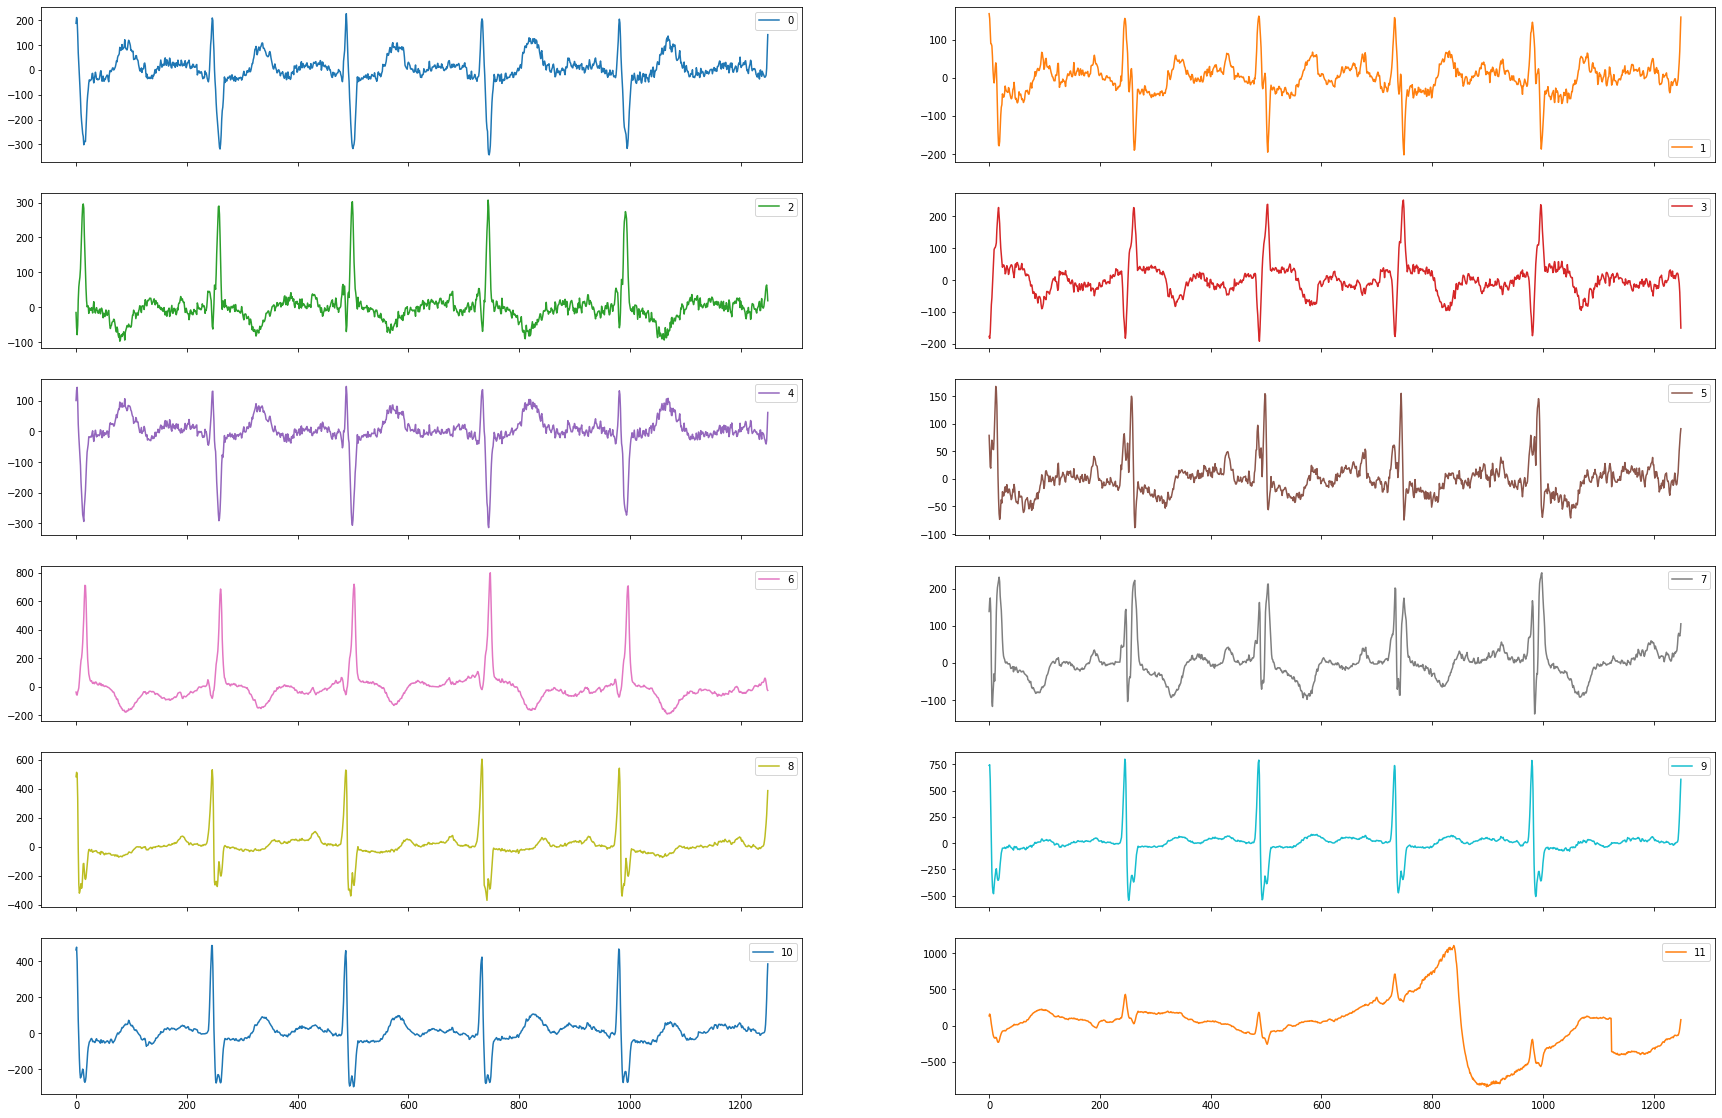

In [107]:
import transformation_funcs as custom_tfms


tfms  = [None,TSMultiLabelClassification()]
# batch_tfms = [TSRandomShift(magnitude=best_params["rand_shift"]),TSMagMulNoise(best_params["noise"]),TSWindowSlicing(magnitude=best_params["window_slice"]),custom_tfms.Resample(scale_factor=best_params["scale"]),TSStandardize(by_sample=True)]

batch_tfms = [TSStandardize(by_sample=True),WindowWarping(100),WindowSlicing(0.2),RandomShift(0.2),MulNoise(0.5),Scale(scale_factor=0.5),]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0,inplace=False)

leads = next(iter(dls.valid))[0][2]
leads = np.array(leads.cpu())
fig = pd.DataFrame(leads).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

In [ ]:
classification_report(y_test, y_pred,target_names = df.columns)

In [13]:
winner = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.795,0.897,0.865,0.821,0.911,0.734,0.852,0.788,0.509]))
winner_ensemble = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.808,0.933,0.875,0.884,0.910,0.826,0.869,0.811,0.624]))
inception = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.93,0.69,0.92,0.96,0.27,0.87,0.42, 0.68,0.84]))
inception_augmented = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.93,0.75,0.91,0.92,0.42,0.91,0.45, 0.68,0.80]))

winner = dict(sorted(winner.items()))
winner_ensemble = dict(sorted(winner_ensemble.items()))
inception = dict(sorted(inception.items()))
inception_augmented = dict(sorted(inception_augmented.items()))
df = pd.DataFrame([winner,winner_ensemble,inception,inception_augmented],index=["winner","winner_ensemble","inception","inception_augmented"]).T

In [16]:
df["better"] = df["winner_ensemble"]<df["inception_augmented"]
df

,winner,winner_ensemble,inception,inception_augmented,better
AF,0.897,0.933,0.92,0.91,False
I-AVB,0.865,0.875,0.87,0.91,True
LBBB,0.821,0.884,0.96,0.92,True
PAC,0.734,0.826,0.42,0.45,False
PVC,0.852,0.869,0.69,0.75,False
RBBB,0.911,0.910,0.93,0.93,True
STD,0.788,0.811,0.84,0.80,False
STE,0.509,0.624,0.27,0.42,False
normal,0.795,0.808,0.68,0.68,False
